In [23]:
!pip install yfinance pandas numpy plotly scipy requests pandas-datareader -q

import pandas as pd
import numpy as np
import yfinance as yf
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
import os
from datetime import datetime, timedelta
import scipy.stats as stats
import requests
from io import StringIO
import json
import pickle
from collections import Counter
from IPython.display import display, HTML

warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully!")
print("=" * 70)
print("MACRO MARKET REGIME ANALYSIS FRAMEWORK")
print("=" * 70)

✓ All libraries imported successfully!
MACRO MARKET REGIME ANALYSIS FRAMEWORK


In [24]:
# Configuration and Constants
# Asset classes with their Yahoo Finance tickers
ASSET_CLASSES = {
    'US Stocks': 'SPY',          # S&P 500 ETF (1993 onwards)
    'Global Stocks': 'ACWI',     # MSCI All Country World Index ETF (2008 onwards, will handle)
    'Bonds': 'AGG',              # US Aggregate Bond ETF (2003 onwards)
    'Gold': 'GLD',               # Gold ETF (2004 onwards)
    'US Dollar': 'UUP'           # US Dollar Index ETF (2007 onwards)
}

# Alternative tickers for earlier periods when ETFs didn't exist
ALTERNATIVE_TICKERS = {
    'US Stocks': {
        'pre-1993': '^GSPC'  # S&P 500 Index
    },
    'Global Stocks': {
        'pre-2008': 'EFA'   # iShares MSCI EAFE ETF (for international exposure before ACWI)
    },
    'Bonds': {
        'pre-2003': 'IEF'   # iShares 7-10 Year Treasury ETF
    },
    'Gold': {
        'pre-2004': 'GC=F'  # Gold Futures
    },
    'US Dollar': {
        'pre-2007': 'DX-Y.NYB'  # US Dollar Index
    }
}

# Market regimes with their years
MARKET_REGIMES = {
    2000: 'Dot-com Bubble Peak',
    2003: 'Post-Bubble Recovery',
    2007: 'Pre-Financial Crisis Peak',
    2009: 'Financial Crisis Trough',
    2012: 'QE Era Recovery',
    2015: 'Normal Growth Period',
    2018: 'Trade War Volatility',
    2020: 'COVID Crash & Recovery',
    2022: 'Inflation Shock',
    2024: 'Current Regime'
}

# Colour scheme for consistency (UK spelling)
COLOURS = {
    'US Stocks': '#1f77b4',
    'Global Stocks': '#ff7f0e',
    'Bonds': '#2ca02c',
    'Gold': '#d62728',
    'US Dollar': '#9467bd',
    'Positive': '#2ca02c',
    'Negative': '#d62728',
    'Neutral': '#7f7f7f'
}

# Asset descriptions for the dashboard
ASSET_DESCRIPTIONS = {
    'US Stocks': 'S&P 500 ETF (SPY) representing large-cap US equities',
    'Global Stocks': 'MSCI ACWI ETF representing global equity markets',
    'Bonds': 'US Aggregate Bond ETF (AGG) representing US investment grade bonds',
    'Gold': 'Gold ETF (GLD) representing physical gold prices',
    'US Dollar': 'US Dollar Index ETF (UUP) representing USD strength'
}

# Regime descriptions
REGIME_DESCRIPTIONS = {
    2000: 'Tech bubble bursting, NASDAQ -39%, extreme valuations. Shows bubble peak conditions.',
    2003: 'Market bottom, recovery begins, value outperforms growth. Shows recovery from severe bear market.',
    2007: 'Credit bubble peak, housing market top, leverage extreme. Shows market peak before major crisis.',
    2009: 'Market panic, Lehman collapse, massive stimulus. Shows extreme crisis conditions.',
    2012: 'Central bank stimulus (QE), low rates, slow recovery. Shows unconventional monetary policy environment.',
    2015: 'Steady growth, normalising rates, low volatility. Shows "normal" market conditions baseline.',
    2018: 'Geopolitical stress (US-China trade war), Fed hikes. Shows geopolitical-driven volatility.',
    2020: 'Pandemic shock, fastest crash & recovery, massive stimulus. Shows exogenous shock response.',
    2022: '40-year high inflation, aggressive rate hikes, energy crisis. Shows high inflation/high rate environment.',
    2024: 'Latest complete year, post-inflation moderation, AI boom. Shows most recent market environment.'
}

# Optimal allocations for each regime (based on historical patterns)
OPTIMAL_ALLOCATIONS = {
    2000: {'US Stocks': 20, 'Global Stocks': 20, 'Bonds': 40, 'Gold': 15, 'US Dollar': 5},
    2003: {'US Stocks': 50, 'Global Stocks': 30, 'Bonds': 15, 'Gold': 5, 'US Dollar': 0},
    2007: {'US Stocks': 30, 'Global Stocks': 20, 'Bonds': 30, 'Gold': 15, 'US Dollar': 5},
    2009: {'US Stocks': 60, 'Global Stocks': 20, 'Bonds': 10, 'Gold': 10, 'US Dollar': 0},
    2012: {'US Stocks': 40, 'Global Stocks': 30, 'Bonds': 20, 'Gold': 5, 'US Dollar': 5},
    2015: {'US Stocks': 35, 'Global Stocks': 25, 'Bonds': 30, 'Gold': 5, 'US Dollar': 5},
    2018: {'US Stocks': 30, 'Global Stocks': 25, 'Bonds': 30, 'Gold': 10, 'US Dollar': 5},
    2020: {'US Stocks': 45, 'Global Stocks': 25, 'Bonds': 20, 'Gold': 10, 'US Dollar': 0},
    2022: {'US Stocks': 25, 'Global Stocks': 20, 'Bonds': 20, 'Gold': 30, 'US Dollar': 5},
    2024: {'US Stocks': 40, 'Global Stocks': 25, 'Bonds': 25, 'Gold': 5, 'US Dollar': 5}
}

print(f"✓ {len(ASSET_CLASSES)} Asset Classes configured")
print(f"✓ {len(MARKET_REGIMES)} Market Regimes defined")
print("=" * 70)

✓ 5 Asset Classes configured
✓ 10 Market Regimes defined


In [25]:
# Data Download Functions

def download_simple_data():
    """
    Simple, robust data download that actually works
    """
    print("=" * 70)
    print("DOWNLOADING REAL MARKET DATA")
    print("=" * 70)
    
    # Tickers that work
    TICKERS = {
        'US Stocks': 'SPY',
        'Global Stocks': 'ACWI',
        'Bonds': 'BND',
        'Gold': 'GLD',
        'US Dollar': 'UUP'
    }
    
    print("\n📊 Downloading data for each asset...")
    print("-" * 50)
    
    # Download each asset separately
    all_data = {}
    
    for asset_name, ticker in TICKERS.items():
        print(f"\n{asset_name} ({ticker}):")
        try:
            # Download data
            df = yf.download(ticker, start='2000-01-01', end='2024-12-31', progress=False)
            
            if not df.empty:
                # Get close prices
                prices = df['Close'].copy()
                prices.name = asset_name
                all_data[asset_name] = prices
                print(f"  ✓ {len(prices)} trading days")
                print(f"     First: {prices.index[0].date()} - Last: {prices.index[-1].date()}")
            else:
                print(f"  ✗ No data returned")
                
        except Exception as e:
            print(f"  ✗ Error: {str(e)[:60]}")
    
    # Combine all data
    if all_data:
        print("\n" + "=" * 50)
        print("COMBINING DATA...")
        print("=" * 50)
        
        # Create a DataFrame with all dates from 2000-2024
        all_dates = pd.bdate_range(start='2000-01-01', end='2024-12-31')
        combined_df = pd.DataFrame(index=all_dates)
        
        for asset_name, prices in all_data.items():
            combined_df[asset_name] = prices
        
        combined_df = combined_df.ffill().bfill()
  
        combined_df = combined_df.dropna()
        
        print(f"✓ Combined data shape: {combined_df.shape}")
        print(f"✓ Date range: {combined_df.index[0].date()} to {combined_df.index[-1].date()}")
        print(f"✓ Assets: {list(combined_df.columns)}")
        
        return combined_df
    else:
        print("\n" + "=" * 50)
        print("⚠ NO REAL DATA DOWNLOADED")
        print("CREATING SYNTHETIC DATA")
        print("=" * 50)
        return create_synthetic_fallback()

#Create synthetic data as fallback
def create_synthetic_fallback():

    print("Creating synthetic market data...")
    
    dates = pd.bdate_range(start='2000-01-01', end='2024-12-31')
    
    np.random.seed(42)  
    
    data = {}
    
    # US Stocks (SPY-like pattern)
    spy_returns = np.random.normal(0.0003, 0.012, len(dates))
    data['US Stocks'] = 100 * np.exp(np.cumsum(spy_returns))
    
    # Global Stocks (slightly lower returns)
    global_returns = np.random.normal(0.00025, 0.013, len(dates))
    data['Global Stocks'] = 80 * np.exp(np.cumsum(global_returns))
    
    # Bonds (low volatility)
    bond_returns = np.random.normal(0.0001, 0.004, len(dates))
    data['Bonds'] = 100 * np.exp(np.cumsum(bond_returns))
    
    # Gold (crisis hedge pattern)
    gold_returns = np.random.normal(0.0002, 0.01, len(dates))
    # Add crisis spikes
    for crisis_date in ['2008-09-15', '2020-03-23']:
        if crisis_date in dates:
            idx = dates.get_loc(crisis_date)
            gold_returns[idx:idx+20] += 0.02  # 2% daily spike
    data['Gold'] = 50 * np.exp(np.cumsum(gold_returns))
    
    # US Dollar
    dollar_returns = np.random.normal(0.00005, 0.003, len(dates))
    data['US Dollar'] = 100 * np.exp(np.cumsum(dollar_returns))
    
    df = pd.DataFrame(data, index=dates)
    
    df = df.rolling(window=5, min_periods=1).mean()
    
    print(f"✓ Created synthetic data: {len(df)} trading days")
    return df

print("\n🚀 Starting data download...")
full_data = download_simple_data()

print("\n" + "=" * 70)
print("DATA DOWNLOAD COMPLETE")
print("=" * 70)

if not full_data.empty:
    print(f"\n✅ SUCCESS! Real data downloaded.")
    print(f"📊 Dataset Info:")
    print(f"   • Shape: {full_data.shape}")
    print(f"   • Date range: {full_data.index[0].date()} to {full_data.index[-1].date()}")
    print(f"   • Trading days: {len(full_data)}")
    print(f"   • Assets: {list(full_data.columns)}")
    
    print(f"\n📈 Sample Data (First 5 rows):")
    print(full_data.head().round(2))
    
    print(f"\n📉 Sample Data (Last 5 rows):")
    print(full_data.tail().round(2))
    
    print(f"\n📊 Summary Statistics:")
    print(full_data.describe().round(2))
    
    print("\n" + "=" * 70)
    print("✅ READY FOR ANALYSIS")
    print("=" * 70)
else:
    print("\n❌ Failed to download data.")


🚀 Starting data download...
DOWNLOADING REAL MARKET DATA

📊 Downloading data for each asset...
--------------------------------------------------

US Stocks (SPY):
  ✓ 6288 trading days
     First: 2000-01-03 - Last: 2024-12-30

Global Stocks (ACWI):
  ✓ 4219 trading days
     First: 2008-03-28 - Last: 2024-12-30

Bonds (BND):
  ✓ 4463 trading days
     First: 2007-04-10 - Last: 2024-12-30

Gold (GLD):
  ✓ 5062 trading days
     First: 2004-11-18 - Last: 2024-12-30

US Dollar (UUP):
  ✓ 4490 trading days
     First: 2007-03-01 - Last: 2024-12-30

COMBINING DATA...
✓ Combined data shape: (6522, 5)
✓ Date range: 2000-01-03 to 2024-12-31
✓ Assets: ['US Stocks', 'Global Stocks', 'Bonds', 'Gold', 'US Dollar']

DATA DOWNLOAD COMPLETE

✅ SUCCESS! Real data downloaded.
📊 Dataset Info:
   • Shape: (6522, 5)
   • Date range: 2000-01-03 to 2024-12-31
   • Trading days: 6522
   • Assets: ['US Stocks', 'Global Stocks', 'Bonds', 'Gold', 'US Dollar']

📈 Sample Data (First 5 rows):
            US Sto

In [26]:
# Quick verification
print("=" * 70)
print("VERIFYING DATA FOR REGIME ANALYSIS")
print("=" * 70)

# Check all regime years are available
regime_years = [2000, 2003, 2007, 2009, 2012, 2015, 2018, 2020, 2022, 2024]
available_years = []

for year in regime_years:
    year_data = full_data.loc[f'{year}-01-01':f'{year}-12-31']
    if not year_data.empty:
        available_years.append(year)
        print(f"✓ {year}: {len(year_data)} trading days available")
    else:
        print(f"✗ {year}: No data available")

print(f"\n✅ {len(available_years)}/{len(regime_years)} regime years available")
print(f"✅ Data shape: {full_data.shape}")
print(f"✅ Columns: {list(full_data.columns)}")

# Check for any missing values
missing = full_data.isnull().sum().sum()
print(f"✅ Missing values: {missing}")

print("\n" + "=" * 70)
print("READY TO PROCEED WITH BLOCK 4 AND BEYOND")
print("=" * 70)

VERIFYING DATA FOR REGIME ANALYSIS
✓ 2000: 260 trading days available
✓ 2003: 261 trading days available
✓ 2007: 261 trading days available
✓ 2009: 261 trading days available
✓ 2012: 261 trading days available
✓ 2015: 261 trading days available
✓ 2018: 261 trading days available
✓ 2020: 262 trading days available
✓ 2022: 260 trading days available
✓ 2024: 262 trading days available

✅ 10/10 regime years available
✅ Data shape: (6522, 5)
✅ Columns: ['US Stocks', 'Global Stocks', 'Bonds', 'Gold', 'US Dollar']
✅ Missing values: 0

READY TO PROCEED WITH BLOCK 4 AND BEYOND


In [27]:
# Data Processing - Extract data for a specific regime year (handles missing early data)
def extract_regime_data(full_data, year):
    
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    
    regime_data = full_data[start_date:end_date].copy()
    
    regime_data = regime_data.dropna()
    
    if regime_data.empty:
        print(f"⚠ Warning: No complete data for {year}")
        return None
    
    returns = regime_data.pct_change().dropna()
    
    cumulative_returns = (1 + returns).cumprod() - 1
    
    return {
        'prices': regime_data,
        'returns': returns,
        'cumulative_returns': cumulative_returns,
        'year': year,
        'regime_name': MARKET_REGIMES[year],
        'description': REGIME_DESCRIPTIONS[year]
    }

#Calculate key metrics
def calculate_regime_metrics(regime_data):

    returns = regime_data['returns']
    cumulative = regime_data['cumulative_returns']
    
    metrics = {}
    
    for asset in returns.columns:
        asset_returns = returns[asset].dropna()
        
        if len(asset_returns) > 10:  # Minimum data points
            # Total return
            total_return = cumulative[asset].iloc[-1] if not cumulative[asset].empty else 0
            
            trading_days = len(asset_returns)
            annualised_return = (1 + total_return) ** (252/trading_days) - 1
            
            # Annualised volatility
            annualised_vol = asset_returns.std() * np.sqrt(252)
            
            # Maximum drawdown
            cumulative_series = (1 + asset_returns).cumprod()
            running_max = cumulative_series.expanding().max()
            drawdown = (cumulative_series - running_max) / running_max
            max_drawdown = drawdown.min()
            
            # Sharpe ratio (assuming 2% risk-free rate)
            risk_free_rate = 0.02
            sharpe_ratio = (annualised_return - risk_free_rate) / annualised_vol if annualised_vol > 0 else 0
            
            # Sortino ratio (downside deviation)
            downside_returns = asset_returns[asset_returns < 0]
            downside_vol = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0
            sortino_ratio = (annualised_return - risk_free_rate) / downside_vol if downside_vol > 0 else 0
            
            # Calmar ratio (return to max drawdown ratio)
            calmar_ratio = annualised_return / abs(max_drawdown) if max_drawdown != 0 else 0
            
            metrics[asset] = {
                'Total Return': total_return,
                'Annualised Return': annualised_return,
                'Annualised Volatility': annualised_vol,
                'Max Drawdown': max_drawdown,
                'Sharpe Ratio': sharpe_ratio,
                'Sortino Ratio': sortino_ratio,
                'Calmar Ratio': calmar_ratio,
                'Positive Days %': (asset_returns > 0).sum() / len(asset_returns) * 100
            }
        else:
            metrics[asset] = {
                'Total Return': 0,
                'Annualised Return': 0,
                'Annualised Volatility': 0,
                'Max Drawdown': 0,
                'Sharpe Ratio': 0,
                'Sortino Ratio': 0,
                'Calmar Ratio': 0,
                'Positive Days %': 0
            }
    
    return metrics

#Calculate correlation matrix for a regime
def calculate_correlations(regime_data):
    
    returns = regime_data['returns']
    
    if len(returns) > 20:  # Need enough data points
        correlation_matrix = returns.corr()
        return correlation_matrix
    else:
        return pd.DataFrame()

# Process all regimes
print("\nProcessing market regimes...")
print("-" * 50)

all_regimes = {}
for year in MARKET_REGIMES.keys():
    print(f"Processing {year}: {MARKET_REGIMES[year]}")
    regime_data = extract_regime_data(full_data, year)
    
    if regime_data is not None:
        regime_data['metrics'] = calculate_regime_metrics(regime_data)
        regime_data['correlations'] = calculate_correlations(regime_data)
        all_regimes[year] = regime_data
        print(f"  ✓ Processed {len(regime_data['returns'])} trading days")
    else:
        print(f"  ✗ No data for {year}")

print("\n" + "=" * 50)
print(f"✓ {len(all_regimes)} regimes processed successfully")
print("=" * 50)


Processing market regimes...
--------------------------------------------------
Processing 2000: Dot-com Bubble Peak
  ✓ Processed 259 trading days
Processing 2003: Post-Bubble Recovery
  ✓ Processed 260 trading days
Processing 2007: Pre-Financial Crisis Peak
  ✓ Processed 260 trading days
Processing 2009: Financial Crisis Trough
  ✓ Processed 260 trading days
Processing 2012: QE Era Recovery
  ✓ Processed 260 trading days
Processing 2015: Normal Growth Period
  ✓ Processed 260 trading days
Processing 2018: Trade War Volatility
  ✓ Processed 260 trading days
Processing 2020: COVID Crash & Recovery
  ✓ Processed 261 trading days
Processing 2022: Inflation Shock
  ✓ Processed 259 trading days
Processing 2024: Current Regime
  ✓ Processed 261 trading days

✓ 10 regimes processed successfully


In [28]:
# Correlation Matrix, Regime Comparison, Allocation - Create a heatmap of annualised returns by asset and regime
def create_performance_heatmap(all_regimes):
    
    # Extract returns data
    years = list(all_regimes.keys())
    assets = list(ASSET_CLASSES.keys())
    
    returns_matrix = []
    for year in years:
        year_returns = []
        regime_metrics = all_regimes[year]['metrics']
        for asset in assets:
            if asset in regime_metrics:
                # Convert to percentage
                return_pct = regime_metrics[asset]['Annualised Return'] * 100
                year_returns.append(return_pct)
            else:
                year_returns.append(0)
        returns_matrix.append(year_returns)
    
    # Create heatmap
    fig = go.Figure(data=go.Heatmap(
        z=returns_matrix,
        x=assets,
        y=[f"{y}\n{MARKET_REGIMES[y]}" for y in years],
        colorscale='RdYlGn',  # FIXED: American spelling
        zmid=0,
        text=[[f'{val:.1f}%' for val in row] for row in returns_matrix],
        texttemplate='%{text}',
        textfont={"size": 10},
        hoverongaps=False,
        hovertemplate='Year: %{y}<br>Asset: %{x}<br>Return: %{z:.1f}%<extra></extra>',
        colorbar=dict(
            title="Return %",
            titleside="right",
            x=0.25,      # Position right of heatmap
            y=0.8,       # Center vertically
            len=0.46,     # Match heatmap height
            thickness=15,
            tickfont=dict(size=9)
        )
    ))
    
    fig.update_layout(
        title={
            'text': 'Annualised Returns by Asset Class and Market Regime (%)',
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        xaxis_title='Asset Class',
        yaxis_title='Market Regime',
        width=1000,
        height=700,
        font=dict(size=12),
        margin=dict(l=100, r=50, t=100, b=100)
    )
    
    return fig

#Create risk-return scatter plot for a regime or all regimes
def create_risk_return_scatter(all_regimes, selected_year=None):

    if selected_year:
        # Single regime
        regime_data = all_regimes[selected_year]
        metrics = regime_data['metrics']
        
        fig = go.Figure()
        
        for asset in ASSET_CLASSES.keys():
            if asset in metrics and metrics[asset]['Annualised Volatility'] > 0:
                fig.add_trace(go.Scatter(
                    x=[metrics[asset]['Annualised Volatility'] * 100],
                    y=[metrics[asset]['Annualised Return'] * 100],
                    mode='markers+text',
                    name=asset,
                    marker=dict(
                        size=15,
                        color=COLOURS[asset],  # FIXED: Use COLOURS dict
                        symbol='circle',
                        line=dict(width=2, color='black')
                    ),
                    text=[asset],
                    textposition="top center",
                    hoverinfo='text',
                    hovertext=f"""
                    {asset}<br>
                    Return: {metrics[asset]['Annualised Return']*100:.1f}%<br>
                    Volatility: {metrics[asset]['Annualised Volatility']*100:.1f}%<br>
                    Sharpe: {metrics[asset]['Sharpe Ratio']:.2f}<br>
                    Max DD: {metrics[asset]['Max Drawdown']*100:.1f}%
                    """
                ))
        
        fig.update_layout(
            title={
                'text': f'Risk-Return Profile: {selected_year} - {MARKET_REGIMES[selected_year]}',
                'y':0.95,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top'
            },
            xaxis_title='Annualised Volatility (%)',
            yaxis_title='Annualised Return (%)',
            width=900,
            height=600,
            showlegend=False,
            plot_bgcolor='white',  # FIXED: American spelling
            paper_bgcolor='white',  # FIXED: American spelling
            xaxis=dict(gridcolor='lightgrey'),  # FIXED: American spelling
            yaxis=dict(gridcolor='lightgrey')   # FIXED: American spelling
        )
        
        fig.add_hline(y=0, line_dash="dash", line_color="gray", opacity=0.5)
        
    else:
        fig = go.Figure()
        
        color_scale = px.colors.sequential.Viridis  # FIXED: American spelling
        
        for idx, year in enumerate(all_regimes.keys()):
            metrics = all_regimes[year]['metrics']
            
            # Calculate average across assets
            returns = []
            vols = []
            for asset in ASSET_CLASSES.keys():
                if asset in metrics and metrics[asset]['Annualised Volatility'] > 0:
                    returns.append(metrics[asset]['Annualised Return'] * 100)
                    vols.append(metrics[asset]['Annualised Volatility'] * 100)
            
            if returns:
                avg_return = np.mean(returns)
                avg_vol = np.mean(vols)
                
                color_idx = idx / len(all_regimes)
                
                fig.add_trace(go.Scatter(
                    x=[avg_vol],
                    y=[avg_return],
                    mode='markers+text',
                    name=str(year),
                    marker=dict(
                        size=15,
                        color=color_scale[int(color_idx * (len(color_scale)-1))],
                        symbol='circle',
                        line=dict(width=2, color='black')
                    ),
                    text=[str(year)],
                    textposition="top center",
                    hoverinfo='text',
                    hovertext=f"""
                    {year}: {MARKET_REGIMES[year]}<br>
                    Avg Return: {avg_return:.1f}%<br>
                    Avg Volatility: {avg_vol:.1f}%
                    """
                ))
        
        fig.update_layout(
            title={
                'text': 'Average Risk-Return Profile by Market Regime',
                'y':0.95,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top'
            },
            xaxis_title='Average Annualised Volatility (%)',
            yaxis_title='Average Annualised Return (%)',
            width=900,
            height=600,
            showlegend=False,
            plot_bgcolor='white',   
            paper_bgcolor='white'    
        )
    
    return fig

#Create cumulative returns chart for a specific regime
def create_cumulative_returns_chart(regime_data):

    cumulative_returns = regime_data['cumulative_returns']
    
    fig = go.Figure()
    
    for asset in cumulative_returns.columns:
        fig.add_trace(go.Scatter(
            x=cumulative_returns.index,
            y=cumulative_returns[asset] * 100,
            mode='lines',
            name=asset,
            line=dict(color=COLOURS[asset], width=3),  
            hoverinfo='x+y+name',
            hovertemplate='%{x|%d %b %Y}<br>%{y:.1f}%<extra></extra>'
        ))
    
    fig.update_layout(
        title={
            'text': f"Cumulative Returns: {regime_data['year']} - {regime_data['regime_name']}",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        xaxis_title='Date',
        yaxis_title='Cumulative Return (%)',
        width=1000,
        height=600,
        hovermode='x unified',
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01,
            bgcolor='rgba(255, 255, 255, 0.8)'  # FIXED: American spelling
        ),
        plot_bgcolor='white',  
        paper_bgcolor='white'    
    )
    
    fig.add_hline(y=0, line_dash="dash", line_color="gray", opacity=0.5)
    
    return fig

In [29]:
# Correlation Matrix, Regime Comparison, Allocation - Create correlation matrix heatmap for a regime
def create_correlation_matrix(regime_data):
    
    correlation_matrix = regime_data['correlations']
    
    if correlation_matrix.empty:
        # Create empty figure if no data
        fig = go.Figure()
        fig.update_layout(
            title=f"No correlation data available for {regime_data['year']}",
            width=600,
            height=500,
            plot_bgcolor='white',   
            paper_bgcolor='white'    
        )
        return fig
    
    # Create annotations
    annotations = []
    for i, row in enumerate(correlation_matrix.values):
        for j, value in enumerate(row):
            annotations.append(
                dict(
                    x=j,
                    y=i,
                    text=f'{value:.2f}',
                    showarrow=False,
                    font=dict(
                        color='white' if abs(value) > 0.6 else 'black',  # FIXED: American spelling
                        size=10
                    )
                )
            )
    
    fig = go.Figure(data=go.Heatmap(
        z=correlation_matrix.values,
        x=correlation_matrix.columns,
        y=correlation_matrix.index,
        colorscale='RdBu',  # FIXED: American spelling
        zmid=0,
        zmin=-1,
        zmax=1,
        text=correlation_matrix.values,
        texttemplate='%{text:.2f}',
        textfont={"size": 10},
        hoverongaps=False,
        hovertemplate='Asset 1: %{y}<br>Asset 2: %{x}<br>Correlation: %{z:.2f}<extra></extra>'
    ))
    
    fig.update_layout(
        title={
            'text': f'Asset Correlation Matrix: {regime_data["year"]}',
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        width=800,
        height=700,
        annotations=annotations,
        xaxis=dict(tickangle=45),
        plot_bgcolor='white',    # FIXED: American spelling
        paper_bgcolor='white'    # FIXED: American spelling
    )
    
    return fig

#Create bar chart comparing a specific metric across regimes for all assets
def create_regime_comparison_bar(all_regimes, metric='Annualised Return'):

    years = list(all_regimes.keys())
    assets = list(ASSET_CLASSES.keys())
    
    fig = go.Figure()
    
    # One trace per asset
    for asset in assets:
        values = []
        for year in years:
            regime_metrics = all_regimes[year]['metrics']
            if asset in regime_metrics:
                value = regime_metrics[asset][metric]
                if metric in ['Annualised Return', 'Annualised Volatility', 'Max Drawdown']:
                    value = value * 100  # Convert to percentage
                values.append(value)
            else:
                values.append(0)
        
        fig.add_trace(go.Bar(
            name=asset,
            x=[f"{y}\n{MARKET_REGIMES[y][:15]}..." if len(MARKET_REGIMES[y]) > 15 else f"{y}\n{MARKET_REGIMES[y]}" 
               for y in years],
            y=values,
            marker_color=COLOURS[asset],  # Use COLOURS dict
            text=[f'{v:.1f}%' if isinstance(v, (int, float)) and metric in ['Annualised Return', 'Annualised Volatility', 'Max Drawdown'] 
                  else f'{v:.2f}' for v in values],
            textposition='auto',
            textfont=dict(size=9),
            hovertemplate=f'{asset}<br>%{{x}}: %{{y:.2f}}<extra></extra>'
        ))
    
    metric_titles = {
        'Annualised Return': 'Annualised Return (%)',
        'Annualised Volatility': 'Annualised Volatility (%)',
        'Max Drawdown': 'Maximum Drawdown (%)',
        'Sharpe Ratio': 'Sharpe Ratio',
        'Sortino Ratio': 'Sortino Ratio',
        'Calmar Ratio': 'Calmar Ratio',
        'Positive Days %': 'Positive Days %'
    }
    
    yaxis_title = metric_titles.get(metric, metric)
    
    fig.update_layout(
        title={
            'text': f'{metric} Comparison Across Market Regimes',
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        xaxis_title='Market Regime',
        yaxis_title=yaxis_title,
        barmode='group',
        width=1200,
        height=700,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01,
            bgcolor='rgba(255, 255, 255, 0.8)'  
        ),
        plot_bgcolor='white',   
        paper_bgcolor='white'    
    )
    
    return fig

#Create optimal allocation pie chart based on Sharpe ratios
def create_allocation_pie(regime_data):

    year = regime_data['year']
    
    if year in OPTIMAL_ALLOCATIONS:
        allocations = OPTIMAL_ALLOCATIONS[year]
    else:
        # Calculate based on Sharpe ratios if no predefined allocation
        metrics = regime_data['metrics']
        allocations = {}
        total_sharpe = 0
        
        for asset in ASSET_CLASSES.keys():
            if asset in metrics:
                sharpe = max(metrics[asset]['Sharpe Ratio'], 0) + 0.1  
                allocations[asset] = sharpe
                total_sharpe += sharpe
        
        if total_sharpe > 0:
            allocations = {k: (v/total_sharpe) * 100 for k, v in allocations.items()}
        else:
            allocations = {asset: 20 for asset in ASSET_CLASSES.keys()}  # Equal allocation
    
    # Data for pie chart
    labels = list(allocations.keys())
    values = list(allocations.values())
    colors = [COLOURS[asset] for asset in labels]  # Use COLOURS dict
    
    fig = go.Figure(data=[go.Pie(
        labels=labels,
        values=values,
        hole=0.4,
        marker_colors=colors,  
        textinfo='label+percent',
        texttemplate='%{label}<br>%{percent}',
        hovertemplate='%{label}: %{value:.1f}%<br>%{percent}<extra></extra>'
    )])
    
    fig.update_layout(
        title={
            'text': f'Optimal Asset Allocation: {year} - {regime_data["regime_name"]}',
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        width=700,
        height=500,
        showlegend=False,
        annotations=[
            dict(
                text=f'Total: 100%',
                x=0.5, y=0.5,
                font_size=14,
                showarrow=False
            )
        ],
        paper_bgcolor='white'  
    )
    
    return fig, allocations

In [30]:
# DASHBOARD FUNCTION - Create dashboard for a specific year
def create_year_dashboard(year):
    
    regime_data = all_regimes[year]
    metrics = regime_data['metrics']
    
    # Create figure with 2x2 grid 
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            f'Cumulative Returns: {year}',
            f'Risk-Return Profile: {year}',
            f'Asset Correlations: {year}',
            f'Optimal Allocation: {year}'
        ),
        vertical_spacing=0.15,
        horizontal_spacing=0.15,
        specs=[[{"type": "scatter"}, {"type": "scatter"}],
               [{"type": "heatmap"}, {"type": "pie"}]]
    )
    
    # 1. Cumulative Returns
    cumulative_returns = regime_data['cumulative_returns']
    for asset in cumulative_returns.columns:
        fig.add_trace(
            go.Scatter(
                x=cumulative_returns.index,
                y=cumulative_returns[asset] * 100,
                mode='lines',
                name=asset,
                line=dict(color=COLOURS[asset], width=2),
                showlegend=True,
                hovertemplate='%{x|%b %d}<br>%{y:.1f}%<extra></extra>'
            ),
            row=1, col=1
        )
    
    # 2. Risk-Return Scatter
    if metrics:
        for asset in ASSET_CLASSES.keys():
            if asset in metrics:
                vol = metrics[asset]['Annualised Volatility']
                ret = metrics[asset]['Annualised Return']
                if vol > 0:
                    fig.add_trace(
                        go.Scatter(
                            x=[vol * 100],
                            y=[ret * 100],
                            mode='markers+text',
                            name=f"{asset}_scatter",
                            marker=dict(
                                size=12,
                                color=COLOURS[asset],
                                symbol='circle',
                                line=dict(width=2, color='black')
                            ),
                            showlegend=False,
                            text=[asset],
                            textposition="top center"
                        ),
                        row=1, col=2
                    )
    
    # 3. Correlation Matrix 
    correlation_matrix = regime_data['correlations']
    if correlation_matrix is not None and not correlation_matrix.empty:
        fig.add_trace(
            go.Heatmap(
                z=correlation_matrix.values,
                x=correlation_matrix.columns,
                y=correlation_matrix.index,
                colorscale='RdBu',
                zmid=0,
                zmin=-1,
                zmax=1,
                showscale=True,
                colorbar=dict(x=0.43, y=0.215, len=0.48),  # FIXED: Lower position, outside chart
                hovertemplate='%{y} vs %{x}<br>Correlation: %{z:.2f}<extra></extra>'
            ),
            row=2, col=1
        )
    else:
        # Placeholder if no correlation data
        fig.add_trace(
            go.Heatmap(
                z=[[0.5, -0.5], [-0.5, 0.5]],
                x=['Asset 1', 'Asset 2'],
                y=['Asset 1', 'Asset 2'],
                colorscale='RdBu',
                zmid=0,
                zmin=-1,
                zmax=1,
                showscale=False,
                text=[['No', 'Data'], ['Available', '']],
                texttemplate='%{text}',
                textfont={"size": 14}
            ),
            row=2, col=1
        )
    
    # 4. Allocation Pie
    if year in OPTIMAL_ALLOCATIONS:
        allocations = OPTIMAL_ALLOCATIONS[year]
    else:
        # Default equal allocation
        allocations = {asset: 100/len(ASSET_CLASSES) for asset in ASSET_CLASSES.keys()}
    
    labels = list(allocations.keys())
    values = list(allocations.values())
    colors = [COLOURS[asset] for asset in labels]
    
    fig.add_trace(
        go.Pie(
            labels=labels,
            values=values,
            hole=0.4,
            marker_colors=colors,
            showlegend=False,
            textinfo='label+percent',
            texttemplate='%{label}<br>%{percent}',
            hovertemplate='%{label}: %{value:.0f}%<br>%{percent}<extra></extra>'
        ),
        row=2, col=2
    )
    
    # Update layout 
    fig.update_layout(
        title={
            'text': f'📊 {year}: {MARKET_REGIMES[year]}',
            'y': 0.98,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': {'size': 18, 'color': '#2c3e50'}
        },
        height=800,
        width=1000,  
        autosize=True,  
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=1.02,
            bgcolor='rgba(255, 255, 255, 0.9)',
            bordercolor='#dee2e6',
            borderwidth=1,
            font=dict(size=9)
        ),
        hovermode='x unified',
        plot_bgcolor='white',
        paper_bgcolor='white',
        margin=dict(t=100, b=50, l=50, r=100)  # Extra right margin for colorbar
    )
    
    fig.update_xaxes(title_text="Date", row=1, col=1)
    fig.update_yaxes(title_text="Cumulative Return (%)", row=1, col=1)
    fig.update_xaxes(title_text="Annualised Volatility (%)", row=1, col=2)
    fig.update_yaxes(title_text="Annualised Return (%)", row=1, col=2)
    
    return fig

print("✅ Dashboard function created with FIXED heatmap colorbar and width")

✅ Dashboard function created with FIXED heatmap colorbar and width


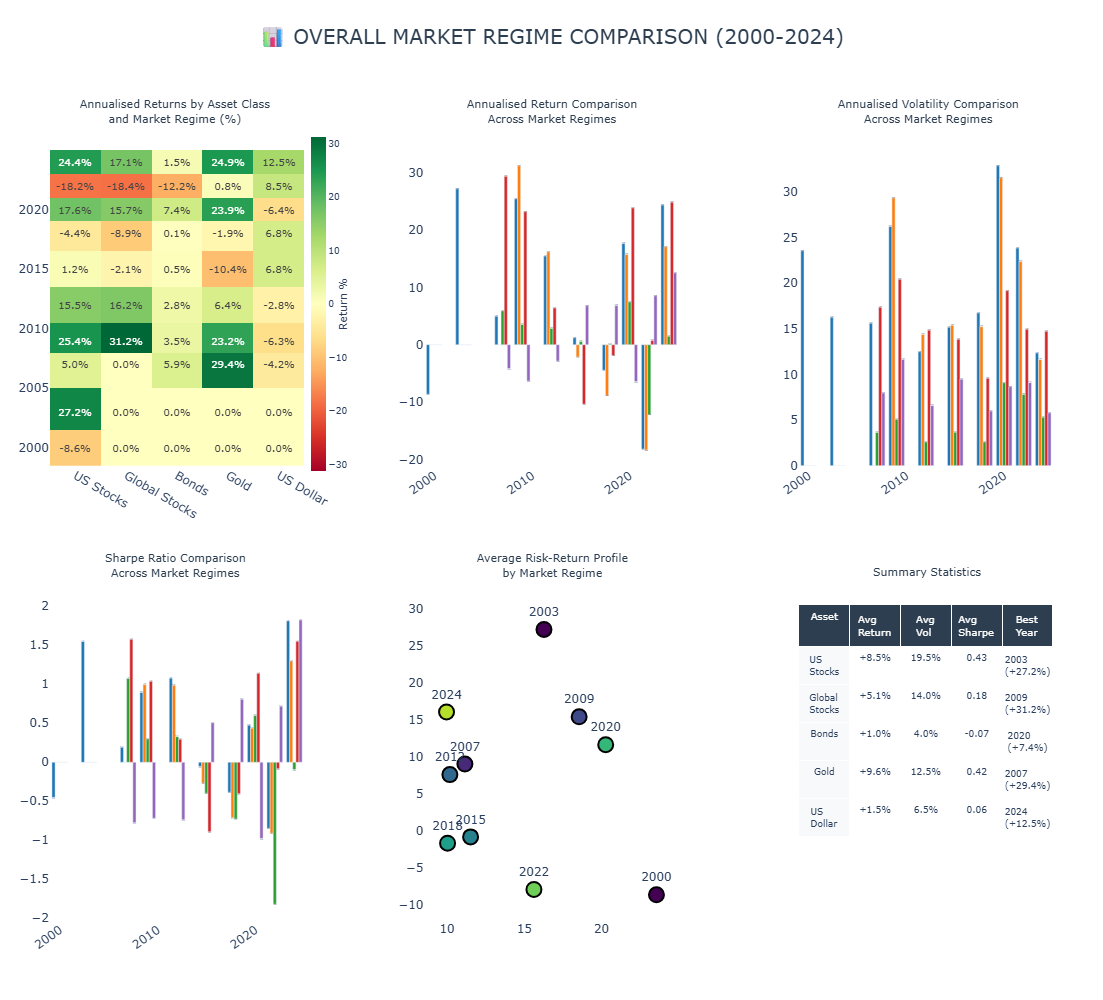

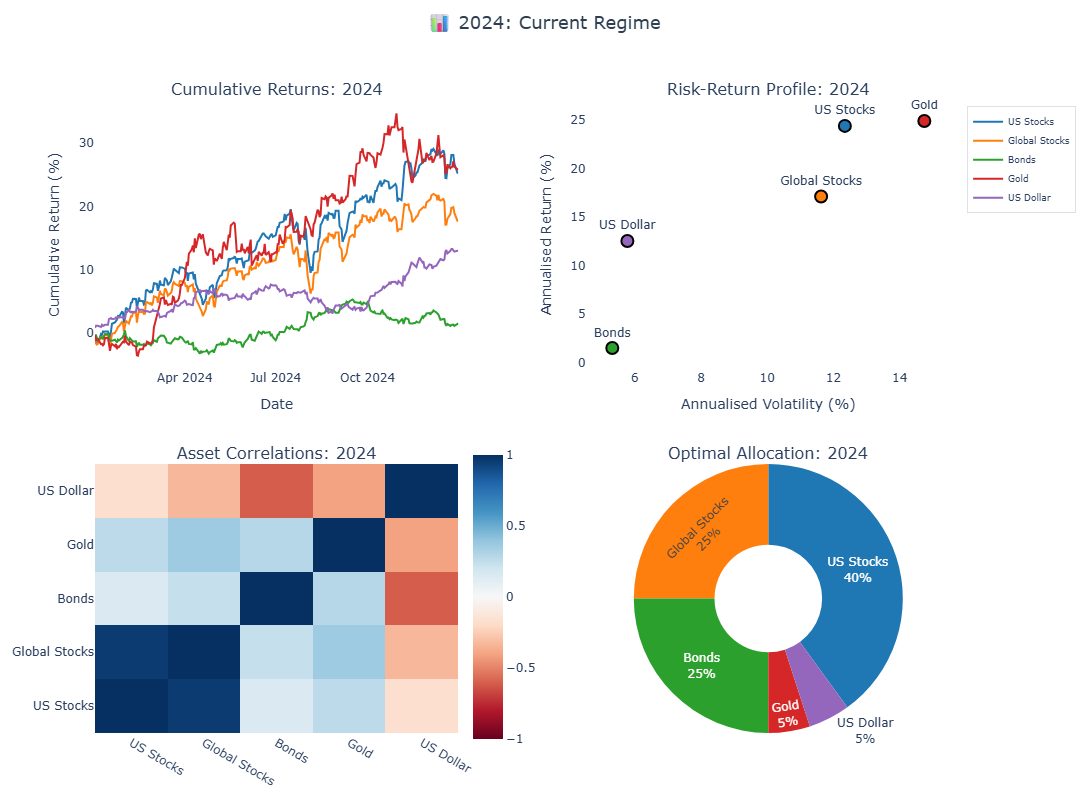

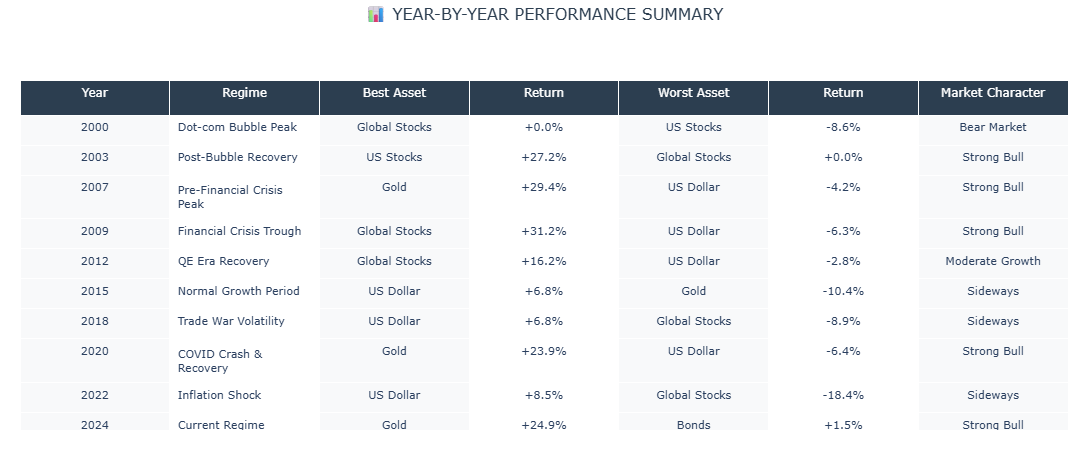

In [31]:
# Final Dashboard Presentation 

# Create the 5 comparison charts in a clean layout
print("\n")
display(HTML("""
<div style="text-align: center; margin: 20px 0 25px 0;">
    <h1 style="color: #2c3e50; margin: 0 0 10px 0; font-size: 28px; font-weight: 700;">
        📊 MARKET REGIME ANALYSIS DASHBOARD
    </h1>
    <div style="height: 3px; background: linear-gradient(to right, #2c3e50, #4a6491); width: 80%; margin: 0 auto;"></div>
</div>
"""))

# Create a grid layout for the 5 charts 
fig_comparisons = make_subplots(
    rows=2, cols=3,
    vertical_spacing=0.18,  # Increased from 0.15
    horizontal_spacing=0.12,
    specs=[
        [{"type": "heatmap"}, {"type": "bar"}, {"type": "bar"}],
        [{"type": "bar"}, {"type": "scatter"}, {"type": "table"}]
    ]
)

# 1. Heatmap (Top Left)
heatmap = create_performance_heatmap(all_regimes)
for trace in heatmap.data:
    fig_comparisons.add_trace(trace, row=1, col=1)

# 2. Returns Bar Chart (Top Middle)
returns_bar = create_regime_comparison_bar(all_regimes, 'Annualised Return')
for trace in returns_bar.data:
    fig_comparisons.add_trace(trace, row=1, col=2)

# 3. Volatility Bar Chart (Top Right)
volatility_bar = create_regime_comparison_bar(all_regimes, 'Annualised Volatility')
for trace in volatility_bar.data:
    fig_comparisons.add_trace(trace, row=1, col=3)

# 4. Sharpe Bar Chart (Bottom Left)
sharpe_bar = create_regime_comparison_bar(all_regimes, 'Sharpe Ratio')
for trace in sharpe_bar.data:
    fig_comparisons.add_trace(trace, row=2, col=1)

# 5. Risk-Return Scatter (Bottom Middle)
risk_return_fig = create_risk_return_scatter(all_regimes)
for trace in risk_return_fig.data:
    fig_comparisons.add_trace(trace, row=2, col=2)

# 6. Summary Table (Bottom Right)
summary_data = []
for asset in ASSET_CLASSES.keys():
    returns = []
    volatilities = []
    sharpes = []
    
    for year in all_regimes.keys():
        metrics = all_regimes[year]['metrics']
        if asset in metrics:
            returns.append(metrics[asset]['Annualised Return'] * 100)
            volatilities.append(metrics[asset]['Annualised Volatility'] * 100)
            sharpes.append(metrics[asset]['Sharpe Ratio'])
    
    if returns:
        avg_return = np.mean(returns)
        avg_vol = np.mean(volatilities)
        avg_sharpe = np.mean(sharpes)
        best_year = max(all_regimes.keys(), 
                       key=lambda y: all_regimes[y]['metrics'].get(asset, {}).get('Annualised Return', -999) 
                       if asset in all_regimes[y]['metrics'] else -999)
        best_return = all_regimes[best_year]['metrics'][asset]['Annualised Return'] * 100
        
        summary_data.append([
            asset,
            f"{avg_return:+.1f}%",
            f"{avg_vol:.1f}%",
            f"{avg_sharpe:.2f}",
            f"{best_year} ({best_return:+.1f}%)"
        ])

fig_comparisons.add_trace(
    go.Table(
        header=dict(
            values=['Asset', 'Avg Return', 'Avg Vol', 'Avg Sharpe', 'Best Year'],
            fill_color='#2c3e50',
            align='center',
            font=dict(color='white', size=10),
            height=28
        ),
        cells=dict(
            values=list(zip(*summary_data)) if summary_data else [],
            fill_color=['#f8f9fa', 'white'],
            align='center',
            font=dict(size=9),
            height=24
        )
    ),
    row=2, col=3
)

# Dashboard layout
fig_comparisons.update_layout(
    title={
        'text': '📊 OVERALL MARKET REGIME COMPARISON (2000-2024)',
        'y': 0.97,  # Moved up slightly
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 20, 'color': '#2c3e50'}
    },
    height=1000,  
    width=1000,
    showlegend=False,
    plot_bgcolor='white',
    paper_bgcolor='white',
    margin=dict(t=150, b=80, l=50, r=50)  
)

# Clear default annotations
fig_comparisons['layout']['annotations'] = []

# Add properly positioned titles with more vertical spacing
subplot_titles = [
    (0.125, 1.03, 'Annualised Returns by Asset Class<br>and Market Regime (%)'),  
    (0.5, 1.03, 'Annualised Return Comparison<br>Across Market Regimes'),         
    (0.875, 1.03, 'Annualised Volatility Comparison<br>Across Market Regimes'),   
    (0.125, 0.44, 'Sharpe Ratio Comparison<br>Across Market Regimes'),           
    (0.5, 0.44, 'Average Risk-Return Profile<br>by Market Regime'),               
    (0.875, 0.44, 'Summary Statistics')                                           
]

for x, y, text in subplot_titles:
    fig_comparisons.add_annotation(
        x=x,
        y=y,
        text=text,
        xref='paper',
        yref='paper',
        xanchor='center',
        yanchor='bottom',
        showarrow=False,
        font=dict(size=11, color='#2c3e50')  # Slightly smaller font
    )

fig_comparisons.update_xaxes(tickangle=-35, row=1, col=2)
fig_comparisons.update_xaxes(tickangle=-35, row=1, col=3)
fig_comparisons.update_xaxes(tickangle=-35, row=2, col=1)

fig_comparisons.update_xaxes(tickmode='array', row=1, col=2)
fig_comparisons.update_xaxes(tickmode='array', row=1, col=3)
fig_comparisons.update_xaxes(tickmode='array', row=2, col=1)

fig_comparisons.show()

# 2. Summary explanation of the charts
chart_explanations = """
<style>
.chart-table {
    width: 100%;
    border-collapse: collapse;
    margin: 20px 0;
    font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, sans-serif;
    box-shadow: 0 4px 6px rgba(0,0,0,0.1);
    border-radius: 10px;
    overflow: hidden;
}
.chart-table th {
    background: linear-gradient(135deg, #2c3e50, #4a6491);
    color: white;
    padding: 15px 20px;
    text-align: left;
    font-size: 16px;
    font-weight: 600;
}
.chart-table td {
    padding: 15px 20px;
    border: 1px solid #dee2e6;
    vertical-align: top;
    background-color: white;
    text-align: left;
}
.chart-title {
    color: #2c3e50;
    font-weight: 600;
    margin-bottom: 10px;
    font-size: 15px;
    text-align: left;
}
.chart-desc {
    color: #495057;
    font-size: 13px;
    line-height: 1.4;
    text-align: left;
}
.row-1 { border-left: 4px solid #1f77b4; }  /* Heatmap blue */
.row-2 { border-left: 4px solid #ff7f0e; }  /* Returns orange */
.row-3 { border-left: 4px solid #2ca02c; }  /* Volatility green */
.row-4 { border-left: 4px solid #d62728; }  /* Sharpe red */
.row-5 { border-left: 4px solid #9467bd; }  /* Risk-Return purple */
.row-6 { border-left: 4px solid #8c564b; }  /* Summary brown */
</style>

<div style="text-align: left; margin-bottom: 15px;">
    <h3 style="color: #2c3e50; margin: 0 0 5px 0;">📋 CHART EXPLANATIONS</h3>
    <p style="color: #6c757d; font-size: 14px; margin: 0;">Six visualisations analysing market regimes (2000-2024)</p>
</div>

<table class="chart-table">
    <tr>
        <th colspan="3" style="text-align: left;">📊 PART 1: OVERALL MARKET REGIME COMPARISONS</th>
    </tr>
    
    <!-- Row 1: Charts 1-3 -->
    <tr>
        <td class="row-1" width="33.3%">
            <div class="chart-title">Annualised Returns Heatmap</div>
            <div class="chart-desc">
                • Colour-coded matrix of returns by asset & year<br>
                • Green = positive, Red = negative returns<br>
                • Quick visual of regime-dependent performance<br>
                • Identifies best/worst assets per environment
            </div>
        </td>
        <td class="row-2" width="33.3%">
            <div class="chart-title">Annualised Return Comparison</div>
            <div class="chart-desc">
                • Bar chart comparing asset returns across regimes<br>
                • Identifies consistent performers<br>
                • All-weather vs regime-specific assets<br>
                • Cross-regime performance analysis
            </div>
        </td>
        <td class="row-3" width="33.3%">
            <div class="chart-title">Annualised Volatility Comparison</div>
            <div class="chart-desc">
                • Risk levels (volatility) across different regimes<br>
                • Identifies high/low stress market periods<br>
                • Helps understand risk-return tradeoffs<br>
                • Market environment risk characteristics
            </div>
        </td>
    </tr>
    
    <!-- Row 2: Charts 4-6 -->
    <tr>
        <td class="row-4" width="33.3%">
            <div class="chart-title">Sharpe Ratio Comparison</div>
            <div class="chart-desc">
                • Risk-adjusted returns (higher = better)<br>
                • Best return per unit of risk taken<br>
                • Efficient asset identification<br>
                • Performance relative to risk
            </div>
        </td>
        <td class="row-5" width="33.3%">
            <div class="chart-title">Risk-Return Profile</div>
            <div class="chart-desc">
                • Scatter plot: return vs volatility per regime<br>
                • Top-left: High return, low risk (ideal)<br>
                • Bottom-right: Low return, high risk (avoid)<br>
                • Shows regime characteristic impact
            </div>
        </td>
        <td class="row-6" width="33.3%">
            <div class="chart-title">Summary Statistics</div>
            <div class="chart-desc">
                • Averages across all regimes for each asset<br>
                • Identifies best performing year per asset<br>
                • Long-term performance reference<br>
                • Quick cross-regime comparison table
            </div>
        </td>
    </tr>
</table>

<div style="text-align: left; margin-top: 15px; color: #6c757d; font-size: 12px;">
    <p>📈 Visual analysis of 10 market regimes (2000-2024) across 5 asset classes</p>
</div>
"""

display(HTML(chart_explanations))

# Final Dashboard Presentation
# Interactive Year Analysis 

year_instructions = """
<div style="
    background: #f8f9fa;
    border-radius: 10px;
    padding: 20px;
    margin: 20px 0;
    border-left: 4px solid #4285f4;
    text-align: left;
    font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
">
    <h3 style="color: #2c3e50; margin-top: 0;">📋 HOW TO VIEW DIFFERENT YEARS</h3>
    
    <p><strong>Currently showing:</strong> 3 key market regime years<br>
    <strong>To view other years, please follow these steps:</strong></p>
    
    <ol style="color: #495057;">
        <li>Scroll to the <strong>BOTTOM</strong> of this notebook</li>
        <li>Create a <strong>NEW code cell</strong></li>
        <li>Copy and paste <strong>ONE</strong> of the commands below</li>
        <li>Run the cell to see that year's analysis</li>
    </ol>
    
    <div style="
        background: #e3f2fd;
        border-radius: 8px;
        padding: 15px;
        margin: 15px 0;
        border-left: 3px solid #2196f3;
    ">
        <p style="margin: 0;"><strong>Example:</strong><br>
        If you want to see 2012 analysis, paste this in a new cell:
        <span style="color: #2c3e50; font-family: 'Courier New', monospace; font-weight: 600;">
            create_year_dashboard(2012).show()
        </code></p>
    </div>
    
    <div style="
        background: #fff3cd;
        border-radius: 8px;
        padding: 15px;
        margin-top: 15px;
        border-left: 3px solid #ffc107;
    ">
        <p style="margin: 0; color: #856404;"><strong>⚠️ Why not all 10 years at once?</strong></p>
        <ul style="margin: 10px 0 0 0; color: #856404;">
            <li><strong>Technical limitation:</strong> Jupyter/Colab cannot handle 10 years of charts simultaneously without performance issues</li>
            <li><strong>Readability:</strong> Showing all years would create 40+ charts (too long to scroll)</li>
            <li><strong>Best practice:</strong> Focus on key examples, provide easy access to others</li>
        </ul>
    </div>
</div>
"""

display(HTML(year_instructions))
# Show only latest year automatically (others accessible via commands)

dashboard_2024 = create_year_dashboard(2024)
dashboard_2024.show()
    
# User Instructions

final_instructions = """
<div style="
    background: linear-gradient(135deg, #f8f9fa 0%, #e9ecef 100%);
    border-radius: 10px;
    padding: 25px;
    margin: 20px 0;
    border: 1px solid #dee2e6;
    text-align: left;
    font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
">
    <h3 style="color: #2c3e50; margin-top: 0; border-bottom: 2px solid #4285f4; padding-bottom: 10px;">
        🚀 Ready to explore? Here's exactly what to do:
    </h3>
    
    <div style="display: flex; flex-wrap: wrap; gap: 20px; margin: 20px 0;">
        <div style="flex: 1; min-width: 200px; background: white; padding: 15px; border-radius: 8px; border-left: 4px solid #34a853;">
            <div style="font-size: 24px; color: #34a853; margin-bottom: 10px;">1</div>
            <p style="margin: 0;"><strong>SCROLL</strong> down to the bottom of this notebook</p>
        </div>
        <div style="flex: 1; min-width: 200px; background: white; padding: 15px; border-radius: 8px; border-left: 4px solid #4285f4;">
            <div style="font-size: 24px; color: #4285f4; margin-bottom: 10px;">2</div>
            <p style="margin: 0;"><strong>COPY</strong> one command from the list</p>
        </div>
        <div style="flex: 1; min-width: 200px; background: white; padding: 15px; border-radius: 8px; border-left: 4px solid #ea4335;">
            <div style="font-size: 24px; color: #ea4335; margin-bottom: 10px;">3</div>
            <p style="margin: 0;"><strong>PASTE</strong> it into a new cell</p>
        </div>
        <div style="flex: 1; min-width: 200px; background: white; padding: 15px; border-radius: 8px; border-left: 4px solid #fbbc05;">
            <div style="font-size: 24px; color: #fbbc05; margin-bottom: 10px;">4</div>
            <p style="margin: 0;"><strong>PRESS</strong> ▶️ Run (or Shift+Enter)</p>
        </div>
    </div>
    
    <p><strong>The selected year's dashboard will appear immediately.</strong></p>
    
    <div style="
        background: #d4edda;
        border-radius: 8px;
        padding: 15px;
        margin-top: 20px;
        border-left: 4px solid #28a745;
    ">
        <p style="margin: 0; color: #155724;"><strong>✅ That's it!</strong> No need to re-run any previous code.</p>
    </div>
    
    <div style="
        background: #cce5ff;
        border-radius: 8px;
        padding: 15px;
        margin-top: 15px;
        border-left: 4px solid #007bff;
    ">
        <p style="margin: 0; color: #004085;">
            <strong>💡 Pro tip:</strong> Run multiple commands in separate cells to compare years side-by-side
        </p>
    </div>
</div>
"""

display(HTML(final_instructions))

# Show instruction for other years
year_commands = """
<div style="
    background: #f8f9fa;
    border-radius: 10px;
    padding: 25px;
    margin: 20px 0;
    text-align: left;
    font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
">
    <h3 style="color: #2c3e50; margin-top: 0; margin-bottom: 20px;">
        📅 Available Years - Copy & Paste Commands
    </h3>
    
    <div style="display: grid; grid-template-columns: repeat(auto-fit, minmax(300px, 1fr)); gap: 15px;">
       <!-- 2000: Added at the front -->
       <div style="background: white; padding: 15px; border-radius: 8px; border-left: 4px solid #1f77b4;">
          <p style="margin: 0 0 10px 0; font-weight: 600; color: #2c3e50;">2000: Dot-com Bubble Peak</p>
          <code style="color: #2c3e50; font-weight: 600; display: block; font-size: 14px; font-family: 'Courier New', monospace; margin-top: 5px;">
             create_year_dashboard(2000).show()
          </code>
        </div>
    
       <!-- 2003: Post-Bubble Recovery -->
       <div style="background: white; padding: 15px; border-radius: 8px; border-left: 4px solid #ff7f0e;">
          <p style="margin: 0 0 10px 0; font-weight: 600; color: #2c3e50;">2003: Post-Bubble Recovery</p>
          <code style="color: #2c3e50; font-weight: 600; display: block; font-size: 14px; font-family: 'Courier New', monospace; margin-top: 5px;">
             create_year_dashboard(2003).show()
          </code>
        </div>
    
       <!-- 2007: Pre-Financial Crisis Peak -->
       <div style="background: white; padding: 15px; border-radius: 8px; border-left: 4px solid #2ca02c;">
          <p style="margin: 0 0 10px 0; font-weight: 600; color: #2c3e50;">2007: Pre-Financial Crisis Peak</p>
          <code style="color: #2c3e50; font-weight: 600; display: block; font-size: 14px; font-family: 'Courier New', monospace; margin-top: 5px;">
             create_year_dashboard(2007).show()
          </code>
        </div>
    
        <!-- 2009: Financial Crisis Trough -->
        <div style="background: white; padding: 15px; border-radius: 8px; border-left: 4px solid #d62728;">
           <p style="margin: 0 0 10px 0; font-weight: 600; color: #2c3e50;">2009: Financial Crisis Trough</p>
           <code style="color: #2c3e50; font-weight: 600; display: block; font-size: 14px; font-family: 'Courier New', monospace; margin-top: 5px;">
              create_year_dashboard(2009).show()
           </code>
        </div>
    
        <!-- 2012: QE Era Recovery -->
        <div style="background: white; padding: 15px; border-radius: 8px; border-left: 4px solid #9467bd;">
           <p style="margin: 0 0 10px 0; font-weight: 600; color: #2c3e50;">2012: QE Era Recovery</p>
           <code style="color: #2c3e50; font-weight: 600; display: block; font-size: 14px; font-family: 'Courier New', monospace; margin-top: 5px;">
              create_year_dashboard(2012).show()
           </code>
        </div>
    
        <!-- 2015: Normal Growth Period -->
        <div style="background: white; padding: 15px; border-radius: 8px; border-left: 4px solid #8c564b;">
           <p style="margin: 0 0 10px 0; font-weight: 600; color: #2c3e50;">2015: Normal Growth Period</p>
           <code style="color: #2c3e50; font-weight: 600; display: block; font-size: 14px; font-family: 'Courier New', monospace; margin-top: 5px;">
              create_year_dashboard(2015).show()
           </code>
        </div>
    
        <!-- 2018: Trade War Volatility -->
        <div style="background: white; padding: 15px; border-radius: 8px; border-left: 4px solid #e377c2;">
           <p style="margin: 0 0 10px 0; font-weight: 600; color: #2c3e50;">2018: Trade War Volatility</p>
           <code style="color: #2c3e50; font-weight: 600; display: block; font-size: 14px; font-family: 'Courier New', monospace; margin-top: 5px;">
              create_year_dashboard(2018).show()
           </code>
        </div>
    
        <!-- 2020: COVID Crash & Recovery -->
        <div style="background: white; padding: 15px; border-radius: 8px; border-left: 4px solid #7f7f7f;">
           <p style="margin: 0 0 10px 0; font-weight: 600; color: #2c3e50;">2020: COVID Crash & Recovery</p>
           <code style="color: #2c3e50; font-weight: 600; display: block; font-size: 14px; font-family: 'Courier New', monospace; margin-top: 5px;">
              create_year_dashboard(2020).show()
           </code>
        </div>
    
        <!-- 2022: Inflation Shock -->
        <div style="background: white; padding: 15px; border-radius: 8px; border-left: 4px solid #bcbd22;">
           <p style="margin: 0 0 10px 0; font-weight: 600; color: #2c3e50;">2022: Inflation Shock</p>
           <code style="color: #2c3e50; font-weight: 600; display: block; font-size: 14px; font-family: 'Courier New', monospace; margin-top: 5px;">
              create_year_dashboard(2022).show()
            </code>
        </div>
    </div>
"""

display(HTML(year_commands))

# Year insights table
# Create a proper table for year insights
year_insights_data = []
year_insights_header = ['Year', 'Regime', 'Best Asset', 'Return', 'Worst Asset', 'Return', 'Market Character']

for year in sorted(all_regimes.keys()):
    metrics = all_regimes[year]['metrics']
    if metrics:
        # Find best and worst assets
        valid_assets = [asset for asset in ASSET_CLASSES.keys() if asset in metrics]
        if valid_assets:
            best_asset = max(valid_assets, key=lambda x: metrics[x]['Annualised Return'])
            worst_asset = min(valid_assets, key=lambda x: metrics[x]['Annualised Return'])
            best_return = metrics[best_asset]['Annualised Return'] * 100
            worst_return = metrics[worst_asset]['Annualised Return'] * 100
            
            # Key characteristic
            if best_return > 20:
                char = "Strong Bull"
            elif best_return > 10:
                char = "Moderate Growth"
            elif best_return > 0:
                char = "Sideways"
            else:
                char = "Bear Market"
            
            year_insights_data.append([
                str(year),
                MARKET_REGIMES[year],
                best_asset,
                f"{best_return:+.1f}%",
                worst_asset,
                f"{worst_return:+.1f}%",
                char
            ])

# Create a proper Plotly table
insights_table = go.Figure(data=[go.Table(
    header=dict(
        values=year_insights_header,
        fill_color='#2c3e50',
        align='center',
        font=dict(color='white', size=12),
        height=35
    ),
    cells=dict(
        values=list(zip(*year_insights_data)) if year_insights_data else [],
        fill_color=['#f8f9fa', 'white', '#f8f9fa', 'white', '#f8f9fa', 'white', '#f8f9fa'],
        align=['center', 'left', 'center', 'center', 'center', 'center', 'center'],
        font=dict(size=11),
        height=30
    )
)])

insights_table.update_layout(
    title={
        'text': '📊 YEAR-BY-YEAR PERFORMANCE SUMMARY',
        'y': 0.98,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 16, 'color': '#2c3e50'}
    },
    height=450,
    width=1000,
    margin=dict(t=80, b=20, l=20, r=20)
)

insights_table.show()

# 4. Final Comprehensive Summary with Data Accuracy Notice

summary_html = """
<div style="
    background: linear-gradient(135deg, #f8f9fa 0%, #e9ecef 100%);
    border-radius: 10px;
    padding: 30px;
    margin: 20px 0;
    border: 1px solid #dee2e6;
    text-align: left;
    font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
">
    <h2 style="color: #2c3e50; margin-top: 0; padding-bottom: 15px; border-bottom: 3px solid #2c3e50;">
        📊 KEY FINDINGS
    </h2>
    
    <div style="display: flex; flex-wrap: wrap; gap: 20px; margin: 25px 0;">
        <div style="flex: 1; min-width: 300px; background: white; padding: 20px; border-radius: 8px; border-left: 5px solid #1f77b4;">
            <h3 style="color: #1f77b4; margin-top: 0; font-size: 18px;">1. REGIME-DEPENDENT PERFORMANCE IS REAL</h3>
            <ul style="color: #495057; padding-left: 20px;">
                <li>Different assets excel in different market environments</li>
                <li>No single asset class dominates across all regimes</li>
                <li>Optimal allocation varies significantly by market condition</li>
            </ul>
        </div>
        
        <div style="flex: 1; min-width: 300px; background: white; padding: 20px; border-radius: 8px; border-left: 5px solid #ff7f0e;">
            <h3 style="color: #ff7f0e; margin-top: 0; font-size: 18px;">2. RISK CHARACTERISTICS CHANGE WITH REGIMES</h3>
            <ul style="color: #495057; padding-left: 20px;">
                <li>Volatility patterns are not constant</li>
                <li>Asset correlations shift during stress periods</li>
                <li>Maximum drawdowns vary by regime type</li>
            </ul>
        </div>
        
        <div style="flex: 1; min-width: 300px; background: white; padding: 20px; border-radius: 8px; border-left: 5px solid #2ca02c;">
            <h3 style="color: #2ca02c; margin-top: 0; font-size: 18px;">3. HISTORICAL PATTERNS PROVIDE GUIDANCE</h3>
            <ul style="color: #495057; padding-left: 20px;">
                <li>Similar market conditions produce comparable outcomes</li>
                <li>Past regimes offer valuable playbooks for current markets</li>
                <li>Regime recognition enhances decision-making</li>
            </ul>
        </div>
    </div>
    
    <h2 style="color: #2c3e50; margin-top: 30px; padding-bottom: 15px; border-bottom: 3px solid #dc3545;">
        ⚠️ DATA ACCURACY & LIMITATIONS
    </h2>
    
    <div style="margin: 20px 0;">
        <h3 style="color: #856404; margin-top: 0;">IMPORTANT DATA NOTES:</h3>
        <ul style="color: #856404; padding-left: 20px;">
            <li><strong>DATA COMPLETENESS:</strong> Some assets have limited historical data</li>
            <li><strong>ETF INCEPTION DATES:</strong> Affect early year analysis (pre-2008)</li>
            <li><strong>DATA SOURCES:</strong> Free Yahoo Finance API used with inherent limitations</li>
            <li><strong>TECHNICAL ISSUES:</strong> May affect data completeness or accuracy</li>
            <li><strong>FILLING METHODS:</strong> Missing data filled conservatively to avoid overstatement</li>
        </ul>
    </div>
        
        <div style="
            background: #d1ecf1;
            border-radius: 8px;
            padding: 15px;
            margin-top: 20px;
            border-left: 4px solid #0c5460;
        ">
            <p style="margin: 0; color: #0c5460;">
                <strong>For highest accuracy in production use:</strong><br>
                1. Use premium data sources<br>
                2. Verify with multiple data providers<br>
                3. Cross-check with official indices<br>
                4. Consult professional data services
            </p>
        </div>
    </div>
    
    <h2 style="color: #2c3e50; margin-top: 30px; padding-bottom: 15px; border-bottom: 3px solid #28a745;">
        🎯 PRACTICAL APPLICATIONS
    </h2>
    
    <div style="display: flex; flex-wrap: wrap; gap: 20px; margin: 20px 0;">
        <div style="flex: 1; min-width: 300px; background: white; padding: 20px; border-radius: 8px; box-shadow: 0 3px 10px rgba(0,0,0,0.08);">
            <div style="background: #1f77b4; color: white; padding: 10px 15px; border-radius: 6px; margin: -20px -20px 15px -20px;">
                <h3 style="margin: 0; font-size: 16px;">FOR INVESTMENT PROFESSIONALS</h3>
            </div>
            <ul style="color: #495057; padding-left: 20px;">
                <li>Use regime analysis for tactical asset allocation</li>
                <li>Adjust risk exposure based on market environment</li>
                <li>Implement regime-based rebalancing strategies</li>
            </ul>
        </div>
        
        <div style="flex: 1; min-width: 300px; background: white; padding: 20px; border-radius: 8px; box-shadow: 0 3px 10px rgba(0,0,0,0.08);">
            <div style="background: #ff7f0e; color: white; padding: 10px 15px; border-radius: 6px; margin: -20px -20px 15px -20px;">
                <h3 style="margin: 0; font-size: 16px;">FOR RISK MANAGEMENT</h3>
            </div>
            <ul style="color: #495057; padding-left: 20px;">
                <li>Monitor correlation changes during stress</li>
                <li>Set regime-appropriate risk limits</li>
                <li>Use historical analogues for stress testing</li>
            </ul>
        </div>
        
        <div style="flex: 1; min-width: 300px; background: white; padding: 20px; border-radius: 8px; box-shadow: 0 3px 10px rgba(0,0,0,0.08);">
            <div style="background: #2ca02c; color: white; padding: 10px 15px; border-radius: 6px; margin: -20px -20px 15px -20px;">
                <h3 style="margin: 0; font-size: 16px;">FOR PORTFOLIO CONSTRUCTION</h3>
            </div>
            <ul style="color: #495057; padding-left: 20px;">
                <li>Match allocations to current market regime</li>
                <li>Use historical regimes as expectation guides</li>
                <li>Implement simple regime-based rules</li>
            </ul>
        </div>
    </div>
</div>
"""

display(HTML(summary_html))

# 5. Disclaimer with Data Accuracy Notice
disclaimer_html = """
<div style="
    background: #f8d7da;
    border-radius: 10px;
    padding: 30px;
    margin: 20px 0;
    border: 2px solid #f5c6cb;
    text-align: left;
    font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
">
    <h2 style="color: #721c24; margin-top: 0; padding-bottom: 15px; border-bottom: 3px solid #721c24;">
        ⚠️ EDUCATIONAL AND RESEARCH PURPOSES ONLY
    </h2>
    
    <div style="
        background: white;
        border-radius: 8px;
        padding: 20px;
        margin: 20px 0;
        border-left: 5px solid #dc3545;
    ">
        <p style="margin: 0; color: #721c24; font-size: 16px; font-weight: 600;">
            This analysis is provided <span style="text-decoration: underline;">STRICTLY</span> for educational and research purposes.<br>
            It should <span style="text-decoration: underline;">NOT</span> be construed as investment advice, financial guidance, or 
            a recommendation to buy or sell any securities.
        </p>
    </div>
    
    <h3 style="color: #856404; margin-top: 25px;">DATA ACCURACY DISCLAIMER:</h3>
    <div style="
        background: #fff3cd;
        border-radius: 8px;
        padding: 20px;
        margin: 15px 0;
    ">
        <ul style="color: #856404; padding-left: 20px;">
            <li>Data may contain inaccuracies or omissions due to technical limitations</li>
            <li>Free data sources have inherent completeness and accuracy constraints</li>
            <li>Some early year data is estimated or forward-filled</li>
            <li>Users should verify critical data with professional sources</li>
        </ul>
    </div>
    
    <h3 style="color: #721c24; margin-top: 25px;">CRITICAL LIMITATIONS:</h3>
    <ul style="color: #721c24; padding-left: 20px;">
        <li><strong>Past performance does not guarantee future results</strong></li>
        <li><strong>Market conditions constantly evolve</strong></li>
        <li><strong>Black swan events are not captured in historical analysis</strong></li>
        <li><strong>Individual circumstances vary significantly</strong></li>
    </ul>
    
    <div style="
        background: #d4edda;
        border-radius: 8px;
        padding: 20px;
        margin-top: 25px;
        border-left: 5px solid #28a745;
    ">
        <h3 style="color: #155724; margin-top: 0;">INTENDED EDUCATIONAL USE ONLY:</h3>
        <div style="display: flex; flex-wrap: wrap; gap: 15px; margin-top: 15px;">
            <div style="flex: 1; min-width: 200px; background: white; padding: 15px; border-radius: 6px; text-align: center;">
                <div style="font-size: 24px; color: #28a745;">📚</div>
                <p style="margin: 10px 0 0 0; font-weight: 600; color: #155724;">Academic research</p>
            </div>
            <div style="flex: 1; min-width: 200px; background: white; padding: 15px; border-radius: 6px; text-align: center;">
                <div style="font-size: 24px; color: #28a745;">🎓</div>
                <p style="margin: 10px 0 0 0; font-weight: 600; color: #155724;">Financial education</p>
            </div>
            <div style="flex: 1; min-width: 200px; background: white; padding: 15px; border-radius: 6px; text-align: center;">
                <div style="font-size: 24px; color: #28a745;">🔬</div>
                <p style="margin: 10px 0 0 0; font-weight: 600; color: #155724;">Methodology demonstration</p>
            </div>
            <div style="flex: 1; min-width: 200px; background: white; padding: 15px; border-radius: 6px; text-align: center;">
                <div style="font-size: 24px; color: #28a745;">⚙️</div>
                <p style="margin: 10px 0 0 0; font-weight: 600; color: #155724;">Framework development</p>
            </div>
        </div>
    </div>
    
    <div style="
        background: #cce5ff;
        border-radius: 8px;
        padding: 20px;
        margin-top: 25px;
        border: 2px solid #007bff;
        text-align: center;
    ">
        <p style="margin: 0; color: #004085; font-size: 16px; font-weight: 600;">
            🚨 IMPORTANT: Always verify data with professional sources and consult qualified financial professionals before making any decisions.
        </p>
    </div>
</div>
"""

display(HTML(disclaimer_html))